## Tutorial de implementación de DeepDream

### Resumen: 
Se va a pasar una imagen descargada de Internet por un nuevo modelo basado en InceptionV3. Se calcularán las activaciones producidas por esa imagen para dos de las capas de InceptionV3, incrementando la pérdida a través de la exageración de esas activaciones y produciendo así una nueva imagen distorsionada/onírica.

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib as plt

import IPython.display as display
import PIL.Image

#### Selección de una imagen

In [35]:
# URL para descargar la imagen (calabaza de Halloween)
url = 'https://eckerts.com/app/uploads/2021/08/Jack-o-27-Lantern-300x2661-2.jpg'

# Descargar y convertirla en un array
def download(url, max_dim=None):
    name = url.split('/')[-1] # Seleccionar el nombre (final de la URL)
    img_path = tf.keras.utils.get_file(name, origin=url) # Cargar el path
    img = PIL.Image.open(img_path) # Cargar la imagen desde el path
    if max_dim:
        img.thumbnail((max_dim, max_dim)) # Redimensiona la imagen limitando el tamaño
    return np.array(img)

# Normalizar
def deprocess(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)

# Mostrar la imagen
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))


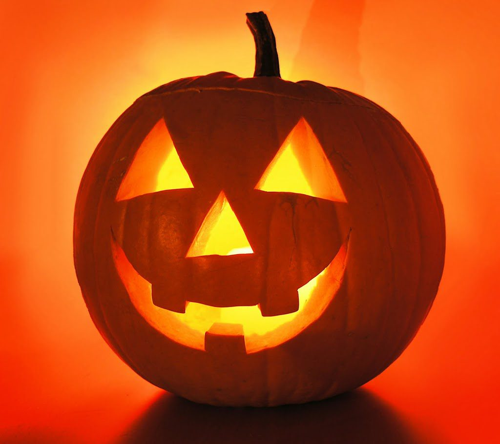

In [36]:
# Reducir las dimensiones facilita el trabajo
original_img = download(url, max_dim=500)
display.display(display.HTML("Jack O'Lantern"))
show(original_img)

#### Preparar modelo de extracción de características (InceptionV3)  
La idea en DeepDream es elegir una capa (o capas) y maximizar la "pérdida" de manera que la imagen "excite" cada vez más las capas. Las capas inferiores producen trazos o patrones simples, mientras que las capas más profundas brindan características sofisticadas en las imágenes

In [37]:
# Quita el top permite añadir capas personalizadas al final / Carga los pesos preentrenados del dataset ImageNet
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [38]:
# Maximizar la activación de estas capas
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Crear el modelo de extracción de características
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

#### Calcular pérdida
La pérdida es la suma de las activaciones en las capas elegidas. La pérdida se normaliza en cada capa para que la contribución de las capas más grandes no supere a las capas más pequeñas. Normalmente, la pérdida es una cantidad que desea minimizar a través del descenso de gradiente. En DeepDream, al contrario, se maximizará esta pérdida a través del ascenso de gradiente.

In [39]:
# Calcula la pérdida sumando el promedio de activaciones de cada capa
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0) #Convierte la imagen en un batch de tamaño 1
    layer_activations = model(img_batch) # Produce un tensor con las activaciones de la capa
    if len(layer_activations) == 1:
        layer_activations = [layer_activations] # Asegura que incluso si solo es 1, es una lista
    
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act) # Calcula la media de todas las activaciones
        losses.append(loss)
    
    return tf.reduce_sum(losses)


#### Ascenso de gradiente

Una vez calculada la pérdida, solo falta calcular los gradientes. Añadiéndolos a la imagen se mejoran los patrones observados por la red, crean en cada paso una imagen que exalta cada vez más las activaciones de ciertas capas. Se utiliza una ``tf.function`` para mejorar el rendimiento

In [40]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    
    """
        Se define la forma y el tipo de datos para que TF 
        valide las entradas y pueda reutilizar el gráfico.
        Se prepara para recibir siempre los mismos tipos de datos,
        mejorando el rendimiento.

        El primer TensorSpec define una especificación de entrada
        donde el tensor tiene una dimensión de color 3 (RGB) y dos
        dimensiones desconocidas/variables (altura y anchura).
        Los dos siguientes con 'shape=[]' son escalares (valor único).
        """
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32)
        )
    )

    def __call__(self, img, steps, step_size):
        """
        Esta función hace un seguimiento del tensor de la imagen, calculando
        la pérdida y los gradientes de esa pérdida para, posteriormente,
        maximizar la pérdida actualizando la imagen en la misma dirección
        que los gradientes, en lugar de en la opuesta como es habitual.
        """
        print('Tracing')
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape: # Abre un contexto necesario para grabar las operaciones y calcular gradientes
                tape.watch(img) # Indica a GradientTape que debe hacer seguimiento al tensor de la imagen
                loss = calc_loss(img, self.model) # Calcula la pérdida de la imagen segun el modelo usado
            
            gradients = tape.gradient(loss, img) # Calcula el gradiente de la pérdida respecto a los pixeles de la iamgen de entrada
            gradients /= tf.math.reduce_std(gradients) + 1e-8 # Normalización

            # Al ser un ascenso de gradiente (en lugar de descenso), se busca maximizar la pérdida
            # Se actualiza la imagen añadiendo directamente los gradientes, porque tienen la misma shape
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1) # Limita los valores del tensor entre -1 y 1

            return loss, img

In [41]:
# Instanciar un objeto de la clase creada usando el modelo creado previamente
deepdream = DeepDream(dream_model)

#### Bucle principal

In [42]:
def run_deepdream_simple(img, steps=100, step_size=0.01):
    # Convertir los datos de uint8 al rango esperado por el modelo
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0

    """
    Bucle para avanzar en bloques de 100 pasos. Ejemplo:
        steps_remainin = 250
        run_steps = 100 (condición if)
        steps_remaining -= run_steps --> 150
        step += 150
    Cuando steps_remaining se sitúa en <= 100, es el último bloque.
    """
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        # Calcula la pérdida y la nueva imagen tras maximizarla
        loss, img = deepdream(img=img, steps=run_steps, step_size=tf.constant(step_size))

        # Limpia la celda para mostrar solo la imagen más reciente (espera hasta que haya una nueva para mostrar)
        display.clear_output(wait=True)

        # Muestra la imagen normalizada
        show(deprocess(img))
        print("Step {}, loss {}".format(step, loss))
    
    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

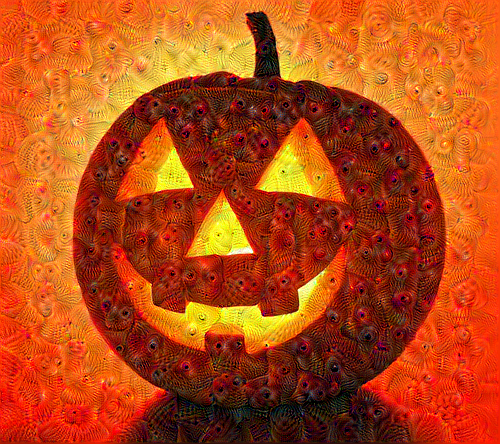

In [46]:
dream_img = run_deepdream_simple(img=original_img, steps=7000, step_size=0.015)